# Homework 4

## FINM 37500: Fixed Income Derivatives

### Mark Hendricks

#### Winter 2024

***

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [56]:
from scipy.stats import norm
from scipy.optimize import minimize

def Blacks_formula(sigma, maturity, strike, F, discount, price='Call'):
    '''
    Inputs: Volatility, Maturity, strike, Forward, discount, and type of option 'Call' or 'Put'
    Returns option's price.
    '''
    vol=sigma
    T=maturity
    K=strike
    Z=discount
    d1=(np.log(F/K)+(((vol**2)*T)/2))/(vol*(T**(1/2)))
    d2=d1-(vol*(T**(1/2)))
    if price=='Call':
        return Z*((F*norm.cdf(d1))-(K*norm.cdf(d2)))
    if price=='Put':
        return Z*((K*norm.cdf(-d2))-(F*norm.cdf(-d1)))

def price_cap_floor(sigma, maturity, strike, F, discount, instrument='Cap', n=4):
    if np.isnan(sigma):
        return np.nan
    if instrument=='Cap':
        price='Call'
    if instrument == 'Floor':
        price='Put'
    tp=0
    for i in range(2,int(n*maturity)+1):
        tp+=Blacks_formula(sigma, (i/n)-(1/n), strike, F[i-1], discount[i-1], price)
    return (100/n)*tp

def forward_vols_from_instrument_prices(cap_prices, maturities, strikes, Fs, discounts, price='Call'):
    cap_prices=np.array(cap_prices)
    maturities=np.array(maturities)
    strikes=np.array(strikes)
    Fs=np.array(Fs)
    discounts=np.array(discounts)

    n=1/(maturities[1]-maturities[0])
    res=np.zeros((len(cap_prices)))
    
    for i, cap_price in enumerate(cap_prices):
        if np.isnan(cap_price):
            res[i]=np.nan
        else:
            tp=0
            for ii in range(i):
                if not np.isnan(res[ii]):
                    tp+=Blacks_formula(res[ii],maturities[ii-1],strikes[i],Fs[ii],discounts[ii],price)
            ttp=cap_price-(tp*100/n)
            def helper(sigma):
                return ((Blacks_formula(sigma, maturities[i-1], strikes[i], Fs[i], discounts[i], price)*100/n) - (ttp))**2
            res[i]=minimize(helper,[0.05], tol=1e-8).x[0]
    return res

def continuous_from_discount(discount, maturity):
    '''Returns the continuous rate from the discount factor and the maturity'''
    return -np.log(discount)/maturity

def compounded_from_discount(discount, maturity, freq=2):
    '''Returns the compounded rate from the discount factor and the maturity'''
    return ((1/discount)**(1/(maturity*freq))-1)*freq

def discount_from_continuous(continuous, maturity):
    '''Returns the discount factor from the continuous rate and the maturity'''
    return np.exp(-continuous*maturity)

def discount_from_compounded(compounded, maturity, freq=2):
    '''Returns the discount factor from the compounded rate and the maturity'''
    return (1+compounded/freq)**(-maturity*freq)

def display_tree(periods, levels, attribute):
    temp=pd.DataFrame()
    for i in range(1,len(levels)+1):
        temp_level=[]
        for j in range(len(levels[-i])):
            temp_level.append(getattr(levels[-i][j],attribute))
        temp[round(periods[-i],2)]=temp_level+['']*(len(levels[-1])-len(temp_level))
    temp.sort_index(axis=1, inplace=True)
    temp.columns=temp.columns.astype(str)
    return temp.style.format("{:.2}")
        
def display_tree_no_attribute(periods, levels):
    temp=pd.DataFrame()
    for i in range(1,len(levels)+1):
        temp_level=[]
        for j in range(len(levels[-i])):
            temp_level.append(levels[-i][j])
        temp[round(periods[-i],2)]=temp_level+['']*(len(levels[-1])-len(temp_level))
    temp.sort_index(axis=1, inplace=True)
    temp.columns=temp.columns.astype(str)
    return temp
    
class tree_convention:
    UP=1
    DOWN=-1
    ORIGIN=0
    TERMINAL=2
    DUMMY=3
    
class interest_node():
    def __init__(self, period, rate, state=tree_convention.DUMMY):
        self.period = period
        self.rate = rate
        self.state = state

    def __repr__(self):
        return 'rate: {:.2%}\nperiod: {}\nstate: {}'.format(self.rate,self.period,self.state)
    
class Interest_Tree():
    def __init__(self, periods, rates=None):
        self.periods = periods
        self.rates = rates
        self.levels = []

    def tree_from_discounts_theta_sigma(self,discounts,theta,sigma,freq=4):
        self.levels.append([interest_node(0,continuous_from_discount(discounts[0],1/freq),tree_convention.ORIGIN)])
        for i in range(1,len(self.periods)):
            tlevel=[]
            ttheta=theta[i-1]
            tsigma=sigma[i-1]
            for j in range(len(self.levels[i-1])):
                trate=self.levels[i-1][j].rate
                tlrate=np.log(trate*100)
                tlrateup=tlrate+(ttheta*(1/freq))+(tsigma*np.sqrt(1/freq))
                trateup=np.exp(tlrateup)/100                   
                node=interest_node(self.periods[i],trateup)
                tlevel.append(node)
                if j == i-1:
                    tlratedown=tlrate+(ttheta*(1/freq))-(tsigma*np.sqrt(1/freq))
                    tratedown=np.exp(tlratedown)/100
                    node=interest_node(self.periods[i],tratedown)
                    tlevel.append(node)
            self.levels.append(tlevel)

    def __repr__(self):
        tree_str = 'Rates_Tree [%]:\n'
        for level_index, level in enumerate(self.levels):
            level_str = '  ' * level_index
            for node in level:
                node_str = '{:.2f}'.format(
                    node.rate*100)
                level_str += node_str + ' '
            tree_str += 'period: {} ||'.format(node.period) + level_str.strip() + '\n'
        return tree_str.strip()
                

class bond_node():
    def __init__(self, period, price, state, maturity,expected_price=None):
        self.period = period
        self.price = price
        self.state = state
        self.maturity = maturity
        self.expected_price=expected_price
        self.rn_probUP=1/2
        self.rn_probDOWN=1/2

    def __repr__(self):
        return 'period: {}\nstate: {}\nprice: {:.2f}\nmaturity: {}'.format(self.period, self.state, self.price, self.maturity)

class Binary_Bond_Tree():
    def __init__(self, periods=None, price=None, face_value=100, interest_tree=None, maturity=None):
        self.periods = np.array(periods)
        if len(price)<=1:
            self.price=price
        else:
            self.price=np.array(price)
        self.face_value = face_value
        self.levels = []
        self.interest_tree = interest_tree
        self.maturity = maturity
        self.thetas=[]
        self.sigmas=np.zeros(())

    def tree_from_sigmas(self,sigmas,periods=None, prices=None):
        sigmas=np.array(sigmas)
        if periods is not None:
            self.periods=periods
        freq=1/(self.periods[1]-self.periods[0])
        if prices is not None:
            self.price=prices
        self.sigmas=sigmas
        for i in range(len(self.periods)-2):
            def helper(theta):
                ttree=Interest_Tree(self.periods[:i+2])
                ttree.tree_from_discounts_theta_sigma(self.price[:i+2]/100,np.append(self.thetas[:i],theta),sigmas[:i+2],freq)
                tjprices=[]
                for j in range(len(ttree.levels[-1])):
                    tjprices.append(self.face_value*np.exp(-ttree.levels[-1][j].rate*(1/freq)))
                for j in range(2,len(ttree.levels)+1):
                    tkprices=[]
                    for k in range(len(ttree.levels[-j])):
                        average=(tjprices[k]+tjprices[k+1])/2
                        tkprice=average*np.exp(-ttree.levels[-j][k].rate*(1/freq))
                        tkprices.append(tkprice)
                    tjprices=tkprices
                if len(tjprices)!=1:
                    print('Error', len(tjprices))
                return (tjprices[0]-self.price[i+1])**2
            theta=minimize(helper,[0.5], tol=1e-8).x[0]
            self.thetas.append(theta)
        ttree=Interest_Tree(self.periods[:-1])
        ttree.tree_from_discounts_theta_sigma(self.price/100,self.thetas,sigmas,freq)
        self.interest_tree=ttree

    def __repr__(self):
        tree_str = 'Binary_Bond_tree:\n'
        tree_str += '                               Maturity: {}\n'.format(self.maturity)
        for level_index, level in enumerate(self.levels[:-1]):
            level_str = '  ' * level_index
            for node in level:
                node_str = '[state: {}, price: {:.2f}]'.format(
                    node.state, node.price)
                level_str += node_str + '  '
            tree_str += 'period: {} '.format(node.period) + level_str.strip() + '\n'
        return tree_str.strip()
    

import numpy.polynomial.polynomial as poly


### SABR

def alpha_polynomial(beta, nu, rho, T, volATM, f):
    
    coefs = np.ones(4)
    coefs[0] = (1-beta)**2 * T / (24*f**(2-2*beta))
    coefs[1] = rho * beta * nu * T / (4*f**(1-beta))
    coefs[2] = 1 + (2-3*rho**2) * nu**2 * T / 24
    coefs[3] = -volATM * f**(1-beta)
    
    return np.poly1d(coefs)

def solve_alpha(beta, nu, rho, T, volATM, f):
    coefs = np.ones(4)
    coefs[3] = (1-beta)**2 * T / (24*f**(2-2*beta))
    coefs[2] = rho * beta * nu * T / (4*f**(1-beta))
    coefs[1] = 1 + (2-3*rho**2) * nu**2 * T / 24
    coefs[0] = -volATM * f**(1-beta)

    roots = poly.polyroots(coefs)
    alpha = np.real(roots[np.abs(np.imag(roots))<1e-6][0])
    return alpha

def zfun(beta, nu, alpha, f, K):
    return (nu/alpha) * (f*K)**((1-beta)/2) * np.log(f/K)

def chi(z, rho):
    return np.log((np.sqrt(1-2*rho*z + z**2) + z - rho) / (1-rho))

def sabr_slim(beta,nu,rho,f,K,T,volATM):

    alpha = solve_alpha(beta, nu, rho, T, volATM, f)
    
    squareNUM = (((1-beta)**2)/24) * (alpha**2)/((f*K)**(1-beta)) + (1/4) * (rho*beta*nu*alpha)/((f*K)**((1-beta)/2))+((2-3*rho**2)/24)*nu**2
    NUM = alpha * (1 + squareNUM * T)
    squareDEN = 1 + (((1-beta)**2)/24) * ((np.log(f/K))**2) + (((1-beta)**4)/1920) * ((np.log(f/K))**4)
    DEN = (f*K)**((1-beta)/2) * squareDEN
    z = zfun(beta,nu,alpha,f,K)
    sigmaB = (NUM/DEN) * (z/chi(z,rho))
        
    if (type(K) is np.float64) | (type(K) is float):
        if (f==K):
            sigmaB = sabrATM(beta,nu,rho,alpha,f,K,T)
    else:
        mask = f==K
        sigmaB[mask] = sabrATM(beta,nu,rho,alpha,f,K[mask],T)
        
    return sigmaB




def sabr(beta,nu,rho,alpha,f,K,T):
   
    squareNUM = (((1-beta)**2)/24) * (alpha**2)/((f*K)**(1-beta)) + (1/4) * (rho*beta*nu*alpha)/((f*K)**((1-beta)/2))+((2-3*rho**2)/24)*nu**2
    NUM = alpha * (1 + squareNUM * T)
    squareDEN = 1 + (((1-beta)**2)/24) * (np.log(f/K)**2) + (((1-beta)**4)/1920) * (np.log(f/K)**4)
    DEN = (f*K)**((1-beta)/2) * squareDEN
    z = zfun(beta,nu,alpha,f,K)        
    sigmaB = (NUM/DEN) * (z/chi(z,rho))
    
    if (type(K) is np.float64) | (type(K) is float):
        if f==K:
            sigmaB = sabrATM(beta,nu,rho,alpha,f,K,T)
    else:
        mask = f==K
        sigmaB[mask] = sabrATM(beta,nu,rho,alpha,f,K[mask],T)
        
    return sigmaB



def sabrATM(beta,nu,rho,alpha,f,K,T):
    brack = (((1-beta)**2)/24) * ((alpha**2)/(f**(2-2*beta))) + (rho * beta * nu * alpha)/(4*f**(1-beta)) + ((2-3*rho**2)/24) * nu**2
    
    sigma = alpha * (1+brack*T) / f**(1-beta)

    return sigma


def get_strikes_from_vol_moneyness(ISCALL,opts,ts):

    phi = ISCALL * 2 - 1

    deltas = pd.DataFrame(np.array([float(col[1:3])/100 for col in opts.columns]) * phi, index=opts.columns,columns = ['delta'])

    strikes = pd.DataFrame(index=opts.index, columns=opts.columns, dtype=float)
    for t in opts.index:
        T = ts.loc[t,'Expiration Option']
        for col in deltas.index:
            strikes.loc[t,col] = bs_delta_to_strike(under = ts.loc[t,'Future Price'], delta=deltas.loc[col,'delta'], sigma=opts.loc[t,col], T=T, isCall=ISCALL)
            
            
    return strikes

def graph_vol_surface_as_strikes(dtgrid,opts,strikes,ts,label):

    fig, ax = plt.subplots(2,1,figsize=(10,10))

    for j, dt in enumerate(dtgrid.columns):

        colorgrid = ['b','r','g']

        for i, tstep in enumerate(dtgrid[dt]):
            tstep = tstep.strftime('%Y-%m-%d')
            plotdata = pd.concat([opts.loc[tstep,:],strikes.loc[tstep,:]],axis=1)
            plotdata.columns = [tstep,'strike']
            plotdata.set_index('strike',inplace=True)
            plotdata.plot(ax=ax[j],color=colorgrid[i]);

            ax[j].axvline(x=ts.loc[tstep,'Future Price'],color=colorgrid[i],linestyle='--')

            if j==0:        
                ax[j].set_title(f'Curve shock: {label}')
            elif j==1:
                ax[j].set_title(f'Underlying shock: {label}')

            if label.split(' ')[-2] == 'ED':
                ax[j].set_xlim(xmin=0,xmax=.08)
            
            plt.tight_layout()

# Data

### Note
This homework continues with the data from `Homework 3`.

### Swaption Vol Data

The file `data/swaption_vol_data_2024-02-20.xlsx` has market data on the implied volatility skews for swaptions. Note that it has several columns:
* `expry`: expiration of the swaption
* `tenor`: tenor of the underlying swap
* `model`: the model by which the volatility is quoted. (All are Black.)
* `-200`, `-100`, etc.: The strike listed as difference from ATM strike (bps). Note that ATM is considered to be the **forward swap rate** which you can calculate.

Your data: ywill use a single row of this data for the `1x4` swaption.
* date: `2024-02-20`
* expiration: 1yr
* tenor: 4yrs

As in `Homework 3`, you will need the forward swap value and the actual strikes being referred to in the provided data (which quotes relative strikes.)

# 1. SABR Volatility Modeling

Use the quoted volatility skew to fit a SABR model.
* Throughout, parameterize, `beta=.75`.

In [57]:
rate_data=pd.read_excel('../data/cap_curves_2024-02-20.xlsx')
discount5=rate_data['discounts'].iloc[19]
discount1=rate_data['discounts'].iloc[3]
discount_swap=discount5/discount1
swap_rate=compounded_from_discount(discount_swap,4,4)
swap_rate*100

3.668557489963309

In [58]:
data=pd.read_excel('../data/swaption_vol_data.xlsx')
vols=np.array(data.iloc[0,6:])/100
strikes=(np.array(data.columns[6:],dtype=float)/10000)+swap_rate
scale=np.sum(rate_data['discounts'].iloc[4:20])/4

## 1.1
Estimate $(\alpha,\rho,\nu)$ via the SABR formula. Feel free to use the `sabr` function in `cmds/volskew.py`.

Report the values of these parameters.

In [59]:
prices=[]
for i in range(len(vols)):
    prices.append(100*Blacks_formula(vols[i],1,strikes[i],swap_rate,scale))
prices

[7.202086165489279,
 4.063798009429432,
 2.7381565055448984,
 2.173136435377561,
 1.6857037328339315,
 1.2796104825461665,
 0.9541191963114497,
 0.5121759203056722,
 0.14674956316667265]

In [60]:
doSLIM = False
BETA = 0.75
F = swap_rate-1e-8
volATM=vols[-5]
Topt=1

def obj_fun(xargs):
    nu = xargs[0]
    rho = xargs[1]
    alpha = xargs[2]
    
    ivolSABR = np.zeros(len(strikes))
    
    for i,strike in enumerate(strikes):
         ivolSABR[i] = sabr(BETA,nu,rho,alpha,F,strike,Topt)
    
    error = ((ivolSABR - vols)**2).sum()
    
    return error


def obj_fun_slim(xargs):
    nu = xargs[0]
    rho = xargs[1]
    ivolSABR = np.zeros(len(strikes))
    
    for i,strike in enumerate(strikes):
         ivolSABR[i] = sabr_slim(BETA,nu,rho,F,strike,Topt,volATM)
    
    error = ((ivolSABR - vols)**2).sum()
    
    return error

if not doSLIM:
    x0 = np.array([.6,0,.1])
    fun = obj_fun
else:
    fun = obj_fun_slim
    x0 = np.array([.6,0,.1])

optim = minimize(fun,x0)
xstar = optim.x
nustar = xstar[0]
rhostar = xstar[1]
   
if doSLIM:
    alphastar = solve_alpha(BETA,nustar,rhostar,Topt,volATM,F)
    ivolSABR = sabr_slim(BETA,nustar,rhostar,F,strikes,Topt,volATM)
else:
    alphastar = xstar[2]
    ivolSABR = sabr(BETA,nustar,rhostar,alphastar,F,strikes,Topt)

error = optim.fun

In [61]:
param = pd.DataFrame([BETA,alphastar,nustar,rhostar,error],index=['beta ($\\beta$)','alpha ($\\alpha$)','nu ($\\nu$)','rho ($\\rho$)','fit error'],columns=['SABR Parameters']).style.format('{:.4f}')
param

,SABR Parameters
beta ($\beta$),0.7500
alpha ($\alpha$),0.1411
nu ($\nu$),0.7758
rho ($\rho$),-0.4259
fit error,0.0001


## 1.2
Create a grid of strikes of `[.0025, .09]`, with grid spacing of `10bps`, (.0010).

Use the SABR model parameterized above to calculate the volatility for each of these strikes.

* Plot the SABR curve, and also include the market quotes in the plot.

* Conceptually, does the SABR curve fit these points well? Perfectly?

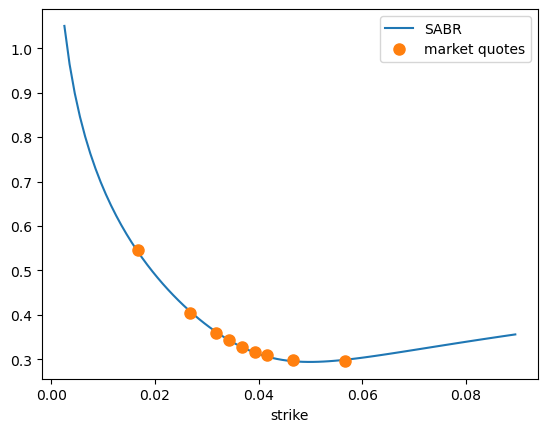

In [62]:
strikegrid = np.arange(.0025,.09,.001)
if doSLIM:
    ivolgrid = sabr_slim(BETA,nustar,rhostar,F,strikegrid,Topt,volATM)
else:
    ivolgrid = sabr(BETA,nustar,rhostar,alphastar,F,strikegrid,Topt)
    
sabrcurve = pd.DataFrame(ivolgrid,index=strikegrid,columns=['SABR'])

volquotes = pd.DataFrame()
volquotes['market quotes']=vols
volquotes['strike'] = strikes
volquotes = volquotes.set_index('strike')

fig, ax = plt.subplots()
sabrcurve.plot(ax=ax)
volquotes.plot(linestyle='',marker='o',markersize=8,ax=ax)
plt.legend()

In [63]:
strikes[-5]

0.03668557489963309

## 1.3
Suppose we want to price the `1y4y` swaption but with a far out-of-the-money strike of `5%`. 

* Use the SABR vol at this strike to price the swaption.

(Note that this strike is far outside the range for which we have market quotes, and even if we do have quotes, they likely are not liquid on a given day.)



In [64]:
NEWSTRIKE = .05

if doSLIM:
    newvol = sabr_slim(BETA,nustar,rhostar,F,NEWSTRIKE,Topt,volATM)
else:
    newvol = sabr(BETA,nustar,rhostar,alphastar,F,NEWSTRIKE,Topt)

newprice = 100 * Blacks_formula(newvol,Topt,NEWSTRIKE, swap_rate,scale)
display(f'Price of the OTM swaption at strike {NEWSTRIKE:.2%} is ${newprice:.4f}.')

'Price of the OTM swaption at strike 5.00% is $0.3313.'

## 1.4

Use the ATM implied volatility to fit $\alpha$, (sometimes denoted $\sigma_0$.) That is, for any choice of $(\rho,\nu)$, solve a quadratic equation to get $\alpha$ as a function of those two parameters, along with $\beta$, which is at its selected (not estimated) value.

Recall that we have a simple relationship between ATM vol and $\alpha$.
$$\sigma_\text{ATM} = \alpha\frac{B}{F^{1-\beta}}$$
where $B$ is defined in the discussion note. It is a quadratic expression of $\alpha$ along with $(\beta,\rho,\nu)$.

This decouples the optimization. We solve for $(\rho,\nu)$ and $\alpha$ as a function of the other two parameters.

Consider using the function `sabrATM` in `cmds/volskew.py`.

***

# 2. SABR and Risk Management

Consider how an **increase** of `50bps` in the underlying rate impacts the price of the `1y4y` ATM swaption.

Here, we are assuming that
* the rate change will impact the forward swap rate directly, one-for-one with other rates.
* the shift happens on `Feb 21, 2024`.

Of course, in reality, a rate change
* may price in early to some degree if it is expected
* may not impact the forward swap rate one-for-one. We would need to model how the discount curve changes and what that change (level, slope, curvature?) would do to the forward swap rate.

## 2.1

Use Black's equation to re-price the `1y4y` swaption with
* the same ATM volatility
* an underlying (forward swap) rate increased `50bps`.
* the same time-to-maturities. (We should decrease these all by 1/365, but we focus here on the delta effects rather than the theta. And it would be a small impact anyone.)

Report 
* the new price
* the change in price divided by `50bps`, (a numerical delta.)

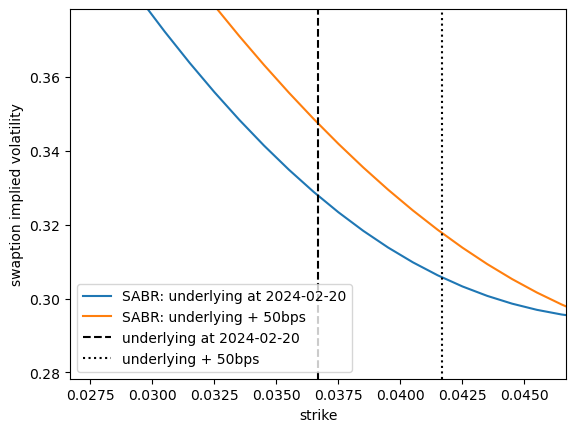

In [65]:
DATE = '2024-02-20'
freqcurve = 4
SHIFT = 50/100/100

sabrcurve.rename(columns={'SABR':f'SABR: underlying at {DATE}'},inplace=True)
if doSLIM:
    sabrcurve[f'SABR: underlying + {SHIFT*100*100:.0f}bps'] = sabr_slim(BETA,nustar,rhostar,F+SHIFT,strikegrid,Topt,volATM)
else:
    sabrcurve[f'SABR: underlying + {SHIFT*100*100:.0f}bps'] = sabr(BETA,nustar,rhostar,alphastar,F+SHIFT,strikegrid,Topt)

fig, ax = plt.subplots()
sabrcurve.plot(ax=ax)
plt.xlim([F-.01,F+.01])
plt.ylim([volATM-.05,volATM+.05])
plt.axvline(F,color='k',linestyle='--',label=f'underlying at {DATE}')
plt.axvline(F+SHIFT,color='k',linestyle=':',label=f'underlying + {SHIFT*100*100:.0f}bps')
plt.ylabel('swaption implied volatility');
plt.xlabel('strike')
plt.legend();

## 2.2

Now, we consider how the volatility may change with the underlying shift of `50bps`.

Using the same SABR parameters from `1.1`, and the strike grid from `1.2`, plot the new SABR curve accounting for the underlying rate shifting up `50bps`.

In [71]:
sabrcurve

,SABR: underlying at 2024-02-20,SABR: underlying + 50bps
0.0025,1.050261,1.067995
0.0035,0.964115,0.983113
0.0045,0.898764,0.918724
0.0055,0.845930,0.866675
0.0065,0.801484,0.822893
...,...,...
0.0855,0.349054,0.324214
0.0865,0.350780,0.325865
0.0875,0.352492,0.327509
0.0885,0.354191,0.329146


In [66]:
fwdswap=swap_rate
idloc = (sabrcurve.index.to_series()-fwdswap).abs().idxmin()

newvols = sabrcurve.loc[idloc]
strikeATM = strikes[-5]

Frange = F + [0,SHIFT]

In [70]:
period_fwd = 1
period_swap = 5

scale=np.sum(rate_data['discounts'].iloc[4:20])/4

blackprices = pd.Series(100 * Blacks_formula(newvols[0],1,NEWSTRIKE,Frange,scale), index=['no change in rates','shift in rates'], name='no change in vol').to_frame().T
blackprices.loc['dynamic vol','shift in rates'] = 100 * Blacks_formula(newvols[1],1,NEWSTRIKE,Frange[1],scale)
blackprices.style.format('{:.2f}')

/var/folders/80/2zgw65dd0msb1psqhn1c195w0000gn/T/ipykernel_94924/3675701037.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  blackprices = pd.Series(100 * Blacks_formula(newvols[0],1,NEWSTRIKE,Frange,scale), index=['no change in rates','shift in rates'], name='no change in vol').to_frame().T
/var/folders/80/2zgw65dd0msb1psqhn1c195w0000gn/T/ipykernel_94924/3675701037.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  blackprices.loc['dynamic vol','shift in rates'] = 100 * Blacks_formula(newvols[1],1,NEWSTRIKE,Frange[1],scale)


,no change in rates,shift in rates
no change in vol,0.46,0.96
dynamic vol,nan,1.06


## 2.3

Calculate the new volatility specifically for the pre-shift ATM strike.

Use this in Black's formula similar to `2.1`, where the only change is the volatility now reflects the shift in the underlying (not the strike).

Report
* the new price
* the change in price divided by `50bps`

In [72]:
dprices = (blackprices[['shift in rates']] - blackprices.loc['no change in vol','no change in rates']).rename(columns={'shift in rates':'price change'})
delta = dprices / SHIFT
delta.style.format('{:.2f}')

,price change
no change in vol,99.59
dynamic vol,121.22


## 2.4

How much different is the (dynamic) delta which accounts for the shift in volatility from the (static) delta in `2.1`?

In [73]:
delta_relative_change = delta.pct_change().loc['dynamic vol','price change']
display(f'Relative change to delta: {delta_relative_change : .2%}.')

'Relative change to delta:  21.72%.'

***